# Overview: Post-Processing Hydro Models: From Explosion to Spectra

In this notebook, we will learn how to post-process hydrodynamic simulation models to create synthetic spectra using TARDIS. The example used here are from a delayed detonation model for thermonuclear supernova, obtained from [Heidelberg Supernova Model Archive (HESMA, see reference within)](https://old-hesma.h-its.org/doku.php?id=data:models:ddt_2013_n100_overview).
This model is pre-parsed into the TARDIS configuration format and contains the ejecta conditions at $t = 100.22 s$ after the start of the explosion.

**The Physics Behind Time Series Modeling in TARDIS**

**Key Insight**: During the photospheric phase, supernovae undergo homologous expansion where density $\rho(t) = \rho(t_0) (\frac{t}{t_0})^{-3}$ while maintaining the same structure in velocity space. This allows us to use a single ejecta model to generate spectra at multiple epochs by adjusting:
- Time since explosion ($t_{\text{exp}}$)
- Bolometric luminosity ($L$) at given time
- Inner boundary velocity  at given time

<div style="background-color:rgb(95, 83, 77); border-left: 4px solid #f44336; padding: 10px; margin: 10px 0;">
<strong> Note:</strong> 
For thermonuclear explosions, the time it takes from the start of explosion to homology is usually short (on the scale of tens of seconds). However, it is often longer for core collapse supernovae (on the scale of hours to days).
</div>


If the hydro model outcome does not provide photospheric velocity, the challenge is determining the correct $v_{\text{inner}}$ at each epoch, which should corresponds to the photospheric location where optical depth $\tau \approx 2/3$.

In TARDIS, this position corresponding to the location where the dilution factor $W=0.5$, which represents 50% of the energy escaped from the inner boundary. 


**Learning Objectives**:<br>
By the end of this notebook, you will be able to:
1. **Visualize and interpret** hydrodynamic model structure (density, abundance profiles)
2. **Understand radioactive decay effects** on abundances over time
3. **Estimate photospheric velocity** (v_inner_boundary in TAR
\DIS) using the dilution factor $W = 0.5$ criterion
5. **Analyze spectral features** using TARDIS built-in visualization tools



# Importing the modules we need 

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from tardis.model import SimulationState
from tardis import run_tardis
from tardis.io.configuration.config_reader import Configuration
from tardis.workflows.util import get_tau_integ
from tardis.visualization import SDECPlotter, LIVPlotter, LineInfoWidget
from tardis.util.base import atomic_number2element_symbol, int_to_roman

from astropy import units as u
from astropy import constants as const


# Loading and Understanding the ejecta Model 

In TARDIS, most of the ejecta model information is processed into the `simulation_state` class, and it can be parsed directly from the config, let's a look how to read the config into a simulation_state WITHOUT actually running TARDIS. Let's checkout the density and abundance profiles. 

See the [source code of the simulation_state](https://github.com/tardis-sn/tardis/blob/fa4c4ea98055ea3bef24d69feba26fb5f74c2ddf/tardis/model/base.py#L38) to see the available attributes and properties. 

In [ ]:
CONFIG_FILE = "configs_and_data/tardis_ddt_2013_n100.yml"
config = Configuration.from_yaml(CONFIG_FILE)
simulation_state = SimulationState.from_csvy(config)

# eg. you can access the density using simulation_state.density
# velocity grid shell inner value using simulation_state.v_inner
# abundance using sim.simulation_state.composition.elemental_mass_fraction


Mass fractions have not been normalized to 1. - normalizing


### TASK: Visualize the Model Structure (Density and abundance profile as a function of velocity)

- The velocity can be accessed through `simulation_state.v_inner` (v_inner/v_outer are the inner/outer velocities of each shell)
- The density can be accessed through `simulation_state.density`
- The abundance can be accessed through `simulation_state.abundance` (which is a pandas dataframe of mass fractions of each isotope (row) across each shell (columns))
---
**Useful information**
`atomic_number2element_symbol` function, which can convert a integer atomic number to the elemental symbol, is imported

In [32]:
# your code here


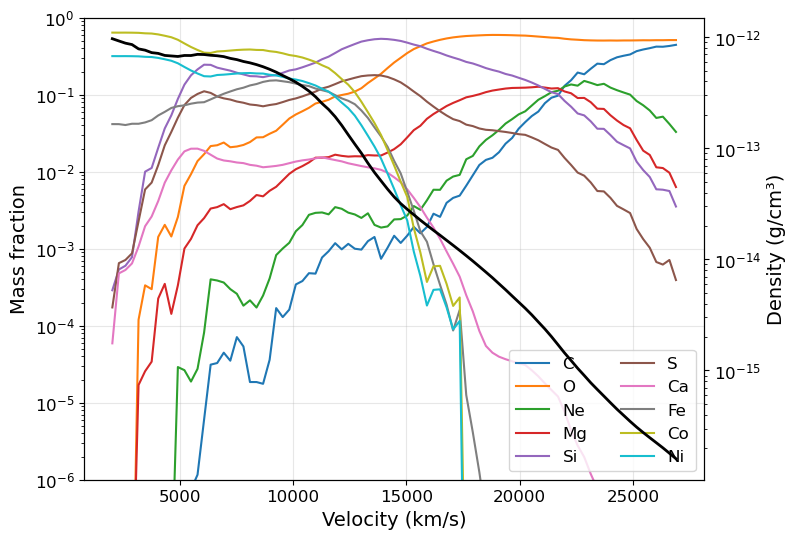

In [ ]:
# Visualize the model structure
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

velocity = simulation_state.v_inner.to(u.km / u.s).value
element_names = [
    atomic_number2element_symbol(Z)
    for Z in sim.simulation_state.composition.elemental_mass_fraction.index
]

# plot the abundance profiles first
for i, element_name in enumerate(element_names):
    ax.plot(
        velocity,
        sim.simulation_state.composition.elemental_mass_fraction.iloc[i].values,
        label=element_name,
    )
ax.set_xlabel("Velocity (km/s)", fontsize=14)
ax.set_ylabel("Mass fraction", fontsize=14)
ax.legend(loc="lower right", fontsize=12, ncol=2)
ax.set_ylim(1e-6, 1e0)
ax.grid(alpha=0.3)

# plot the density profile at the secondary y-axis
ax_twin = ax.twinx()
time_explosion = simulation_state.time_explosion.to(u.day)
density = simulation_state.density.to(u.g / u.cm**3).value
ax_twin.plot(
    velocity,
    density,
    "k-",
    lw=2,
    label=f"Density (g/cm³) at t={time_explosion:.1f} day",
)
ax_twin.set_ylabel("Density (g/cm³)", fontsize=14)

for axs in [ax, ax_twin]:
    axs.tick_params(labelsize=12)
    axs.set_yscale("log")


### Compare the initial density and iron group elements mass fractions vs the time-process ones. 

The profiles you see above from the simulation state is already processed through time assuming the ejecta is expanding homologously, which includes the following:

- <u>**Density**</u>: In the assumption of homologous expansion, the radius ($r$) of the ejecta can be approximated with $r = v\times t$, hence the volume expansion scales with $t^{-3}$, which leads to the density scaling as $\rho(t) = \rho(t_0) (\frac{t}{t_0})^{-3}$.  
    - **The model initial density time is set by the `model_density_time_0` in the csvy file.** 
- <u>**Radiative isotope mass fractions**</u>: If the ejecta contains radiative isotopes, TARDIS decays these isotopes from the model initial isotope time to the specified time since explosion. 
    - **The model initial density time is set by the `model_isotope_time_0` in the csvy file.** 

---
 TASK::
Overplot the initial density profile and the mass fractions (iron group elements ONLY) directly from the csvy file itself, which can be read in using `pd.read_csv(file_path, skiprows=n)` ??????

In [34]:
# your code here

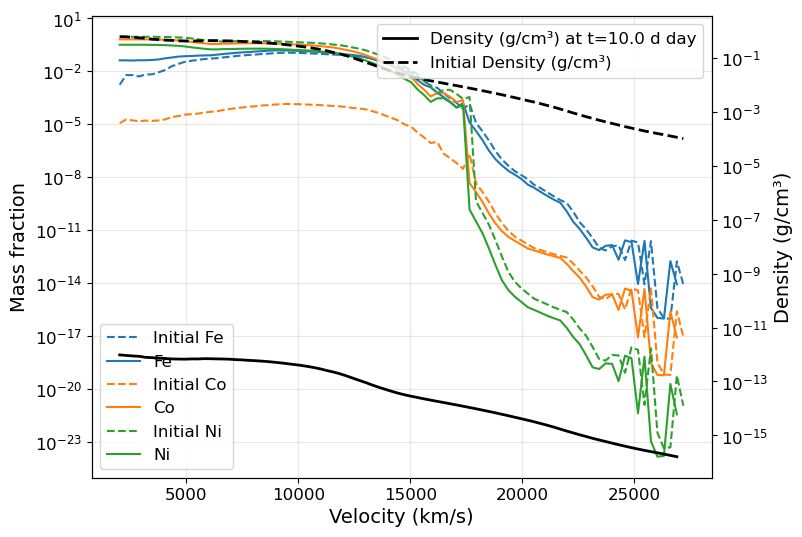

In [ ]:
# Visualize the model structure
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

velocity = simulation_state.v_inner.to(u.km / u.s).value
element_names = [
    atomic_number2element_symbol(Z)
    for Z in sim.simulation_state.composition.elemental_mass_fraction.index
]

## read in the initial profiles
profile_initial = pd.read_csv(
    "configs_and_data/tardis_ddt_2013_n100_profile.csvy", skiprows=35
)
IGE_elements = ["Fe", "Co", "Ni"]


# plot the abundance profiles first
for element in IGE_elements:
    isotopes = [col for col in profile_initial.columns if element in col]
    element_mass_fractions = profile_initial[isotopes].sum(axis=1)
    p = ax.plot(
        profile_initial["velocity"],
        element_mass_fractions,
        label=f"Initial {element}",
        linestyle="--",
    )
    element_index = element_names.index(element)
    ax.plot(
        velocity,
        sim.simulation_state.composition.elemental_mass_fraction.iloc[
            element_index
        ].values,
        label=element,
        color=p[0].get_color(),
    )
ax.set_xlabel("Velocity (km/s)", fontsize=14)
ax.set_ylabel("Mass fraction", fontsize=14)
ax.legend(loc="lower left", fontsize=12, ncol=1)
ax.grid(alpha=0.3)

# plot the density profile at the secondary y-axis
ax_twin = ax.twinx()
time_explosion = simulation_state.time_explosion.to(u.day)
density = simulation_state.density.to(u.g / u.cm**3).value
ax_twin.plot(
    velocity,
    density,
    "k-",
    lw=2,
    label=f"Density (g/cm³) at t={time_explosion:.1f} day",
)
ax_twin.set_ylabel("Density (g/cm³)", fontsize=14)

ax_twin.plot(
    profile_initial["velocity"],
    profile_initial["density"],
    "k--",
    lw=2,
    label="Initial Density (g/cm³)",
)
ax_twin.legend(loc="upper right", fontsize=12)

for axs in [ax, ax_twin]:
    axs.tick_params(labelsize=12)
    axs.set_yscale("log")


# Photospheric Velocity Optimization

TARDIS currently rely on the photospheric assumption (recall from day 1), it is important to set the optimal v_inner_boundary for a specific TARDIS simulation to make sure the synthetic spectrum is physically reasonable. 

The photosphere is defined as the location where the optical depth $\tau = 2/3$. This is where most photons last scatter before escaping. The inner boundary velocity ($v_{\text{inner}}$) should correspond to this photospheric location.

We can iteratively find the optimal $v_{\text{inner}}$ by checking the optical depth of the chosen location of a converging TARDIS simulation. 

Let's start with a example at $t = 10$ days past explosion. We'll walk through the iterative process step by step to find the optimal $v_{\text{inner}}$.

--- 


### Step 1: Set up the time and luminosity

While the initial ejecta profiles doesn't need to be changed, the time snapshot information including the time since explosion and the bolometric luminosity at that time should be updated for each intended time snap. 

**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

Let's first find the bolometric luminosity of the model at 10 days past explosion from the provided `ddt_2013_n100_lightcurve.dat`.
????? (specify what we want them to do )

<details>
<summary><strong>💡 <u>Hint</u> </strong></summary>
The interpolated bolometric luminosity at 10 day should be around 7.35e+42 erg/s. 
</details>


In [ ]:
# your code here

# df_bolo_LC = pd.read_csv("configs_and_data/ddt_2013_n100_lightcurve.dat", sep=r"\s+")
# df_bolo_LC


,time[day],bolometric_luminosity[erg/s]
0,6.16,3.447180e+42
1,6.39,3.688710e+42
2,6.63,3.931710e+42
3,6.88,4.188050e+42
4,7.14,4.454800e+42
...,...,...
66,70.29,1.120750e+42
67,72.93,1.035790e+42
68,75.67,9.572840e+41
69,78.52,8.823940e+41


Luminosity at 10 days: 7.35e+42 erg/s


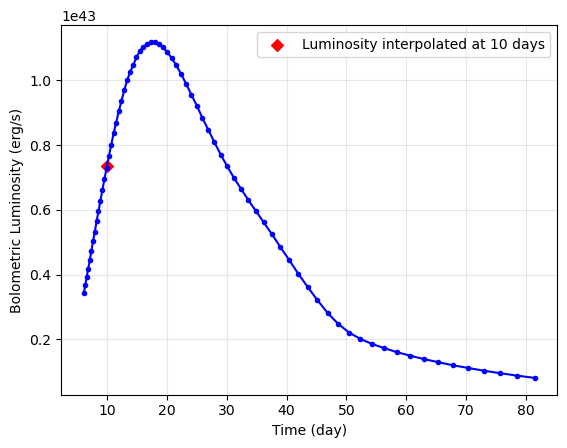

In [37]:
df_bolo_LC = pd.read_csv("configs_and_data/ddt_2013_n100_lightcurve.dat", sep=r"\s+")

# plot the bolometric luminosity
plt.plot(
    df_bolo_LC["time[day]"],
    df_bolo_LC["bolometric_luminosity[erg/s]"],
    "b-",
    marker=".",
)
plt.xlabel("Time (day)")
plt.ylabel("Bolometric Luminosity (erg/s)")

# intepolate the evaluate the bolometric luminosity at 10 days
lum_10_day = np.interp(
    10,
    df_bolo_LC["time[day]"],
    df_bolo_LC["bolometric_luminosity[erg/s]"],
)
plt.scatter(
    10, lum_10_day, marker="D", color="red", label="Luminosity interpolated at 10 days"
)
plt.grid(alpha=0.3)
plt.legend()

print(f"Luminosity at 10 days: {lum_10_day:.2e} erg/s")

Now with the time and luminosity information for the time snapshot, let's update the value in the config! 

You can directly edit the yml file or change the corresponding attributes of the config object that we have already loaded in earlier. 

---
**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

And let's give a first guess of the v_inner_boundary based on your educated guess of the photospheric velocity of a type Ia supernova at 10 days after the explosion and scaled down 3000 km/s, then update the configuration.

**<span style="background-color: rgba(207, 76, 39, 0.3); padding: 4px;">⚠️ Note: </span>**
Usually you can directly modify the `v_inner_boundary` setting in the csvy file, and keep the whole ejecta velocity grid untouched in the csvy file.  Unforuntally, due to a recent restructure of the code base, such option is under testing process and we would need to this in a slightly more painful way -- by manually deleting the shells has velocity smaller than the intended v_inner_boundary.  We suggest to first make a copy of the original csvy file and rename that copy to `tardis_ddt_2013_n100_profile_original.csvy`, and modify the `tardis_ddt_2013_n100_profile.csvy` to change the v_inner_boundary.

In [ ]:
# your code here

# config.supernova.time_explosion = 10 * u.day
# config.supernova.luminosity_requested = ???? * u.erg / u.s

In [39]:
# update the time snapshot info in config
config.supernova.time_explosion = 10 * u.day
config.supernova.luminosity_requested = 7.35e42 * u.erg / u.s

### Step 2: Run Simulation with the initial guessed v_inner value

Now with the updated config and the csvy file that starts at the your guessed v_inner_boundary, Let's run TARDIS with our initial guess and see what happens! 

You can also check the rosseland mean optical depth of a TARDIS simulation, which can be calculated using:

```python
from tardis.workflows.util import get_tau_integ
tau = get_tau_integ(
        sim.plasma,
        sim.opacity_state,
        sim.simulation_state,
    )["rosseland"].to(1)
```
---
**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

Run the simulation, and visualize the shell velocities vs tau after the simulation is converged.


<div style="background-color:rgb(95, 83, 77); border-left: 4px solid #f44336; padding: 10px; margin: 10px 0;">
<strong> READ THIS:</strong> Keep each simulation named differently so that we can compare them later.
</div>



In [58]:
# your code here, keep each simulation named differently so that we can compare them later
# sim_iter1 = run_tardis(
#     config,
#     virtual_packet_logging=True,
#     show_convergence_plots=True,
#     export_convergence_plots=True
# )

BokehModel(combine_events=True, render_bundle={'docs_json': {'28ec8c23-7784-460b-9110-8cd08c6f353b': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': '43792904-2262-4fc9-9aec-f2b4a0f14ab2', …

[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/plasma/properties/ion_population.py:175: UserWarning:

t_rads outside of zeta factor interpolation zeta_min=2000.00 zeta_max=40000.00 - replacing with zeta = 1.0

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/plasma/properties/ion_population.py:175: UserWarning:

t_rads outside of zeta factor interpolation zeta_min=2000.00 zeta_max=40000.00 - replacing with zeta = 1.0

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/plasma/properties/ion_population.py:175: UserWarning:

t_rads outside of zeta factor interpolation zeta_min=2000.00 zeta_max=40000.00 - replacing with zeta = 1.0

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/plasma/properties/ion_population.py:175: UserWarning:

t_rads outside of zeta factor interpolation zeta_min=2000.00 zeta_max=40000.00 - replacing with zeta = 1.0

 (warnings.py:110)


    'data': [{'type': 'scatter', 'uid': '43792904-2262-4fc9-9aec-f2b4a0f14ab2', …

[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/mambaforge/envs/tardis/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/mambaforge/envs/tardis/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)


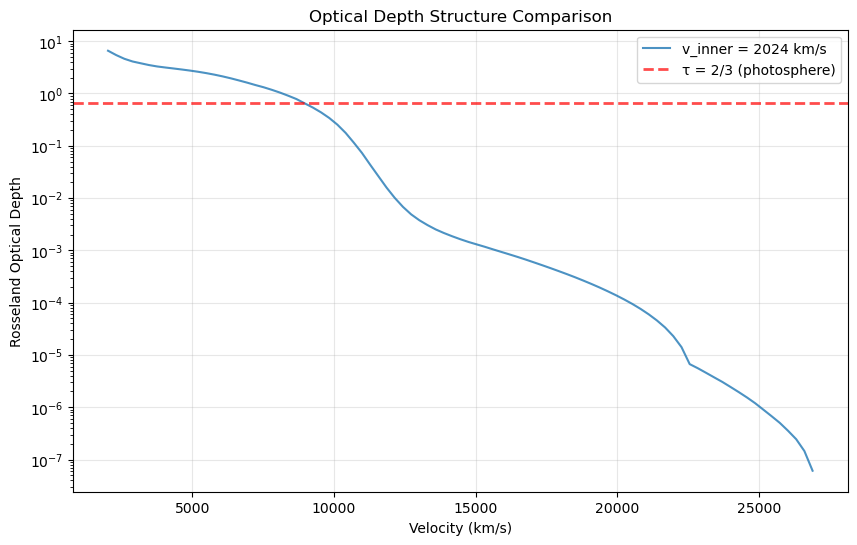

In [ ]:
sim_iter1 = run_tardis(
    config,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
)

# Extract optical depth information
W = sim_iter1.simulation_state.dilution_factor
shell_velocities_iter1 = sim_iter1.simulation_state.geometry.v_inner.to(u.km / u.s)
v_inner_iter1 = shell_velocities_iter1[0].value


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(
    shell_velocities_iter1,
    W,
    alpha=0.8,
    label=f"v_inner = {v_inner_iter1:.0f} km/s ",
)
ax.axhline(
    y=0.5,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="W = 0.5",
)
ax.set_xlabel("Velocity (km/s)")
ax.set_ylabel("Dilution factor")
ax.legend()
ax.set_yscale("log")
ax.grid(alpha=0.3)

## Step 3: Iterate to Find Optimal v_inner_boundary

What you see from the first simulation with the guessed v_inner_boundary value? 

**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

If it's too high/low, identify a new value where the dilution factor (W) is roughly 0.5, **modify the csvy file** and and run another simulation, then plot the dilution factor again.

<div style="background-color:rgb(95, 83, 77); border-left: 4px solid #f44336; padding: 10px; margin: 10px 0;">
<strong> READ THIS:</strong> Due to a recent refactor of the code, the v_inner_boundary setting in the csvy model is not available at the moment (will be fixed soon), so you would have to modify the file manually for now change it, only keep the shells starting from the intended v_inner_boundary in the csv part of the csvy file. 
</div>

Repeat this for at least another 2 iteration, ideally if we are at the optimal location, the first shell dilution factor will stay near the converged value. 

In [43]:
# your code here

BokehModel(combine_events=True, render_bundle={'docs_json': {'fae7de59-1985-46d8-8672-d58143ceb0e1': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': 'eb8d1e90-e4d9-4bb8-91cb-979f7d86579c', …

    'data': [{'type': 'scatter', 'uid': 'eb8d1e90-e4d9-4bb8-91cb-979f7d86579c', …

[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/mambaforge/envs/tardis/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING] 

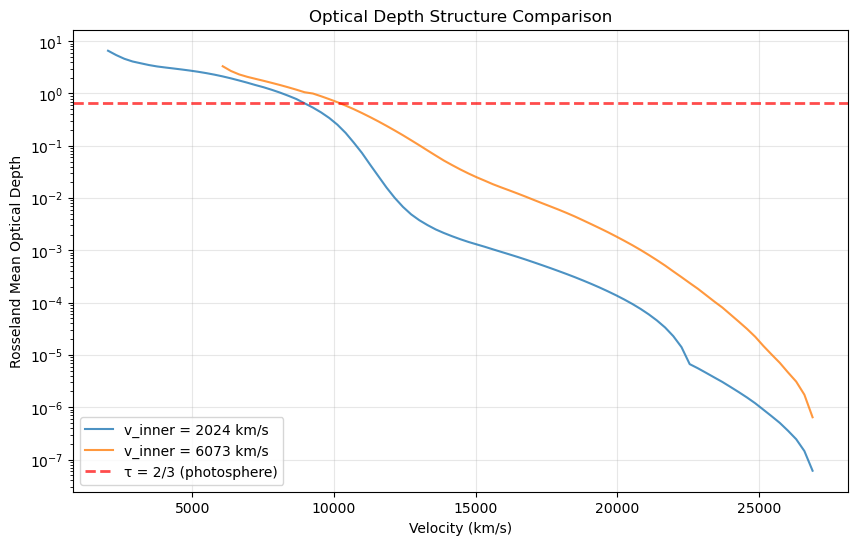

In [ ]:
sim_iter2 = run_tardis(
    config,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
)

sim_s = [sim_iter1, sim_iter2]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for sim in sim_s:
    velocity = sim.simulation_state.v_inner.to(u.km / u.s)
    tau = get_tau_integ(
        sim.plasma,
        sim.opacity_state,
        sim.simulation_state,
    )["rosseland"].to(1)
    v_inner = sim.simulation_state.geometry.v_inner[0].to(u.km / u.s).value
    ax.plot(
        velocity,
        tau,
        alpha=0.8,
        label=f"v_inner = {v_inner:.0f} km/s ",
    )
ax.axhline(
    y=2 / 3,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="W = 0.5",
)
ax.set_xlabel("Velocity (km/s)")
ax.set_ylabel("Rosseland Mean Optical Depth")
ax.set_title("Optical Depth Structure Comparison")
ax.legend()
ax.set_yscale("log")
ax.grid(alpha=0.3)


BokehModel(combine_events=True, render_bundle={'docs_json': {'b7ff2b67-02bb-4810-89f0-b34217edff80': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': '6eb875a3-ab6a-4610-8bdf-7b177180c121', …

    'data': [{'type': 'scatter', 'uid': '6eb875a3-ab6a-4610-8bdf-7b177180c121', …

[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/mambaforge/envs/tardis/li

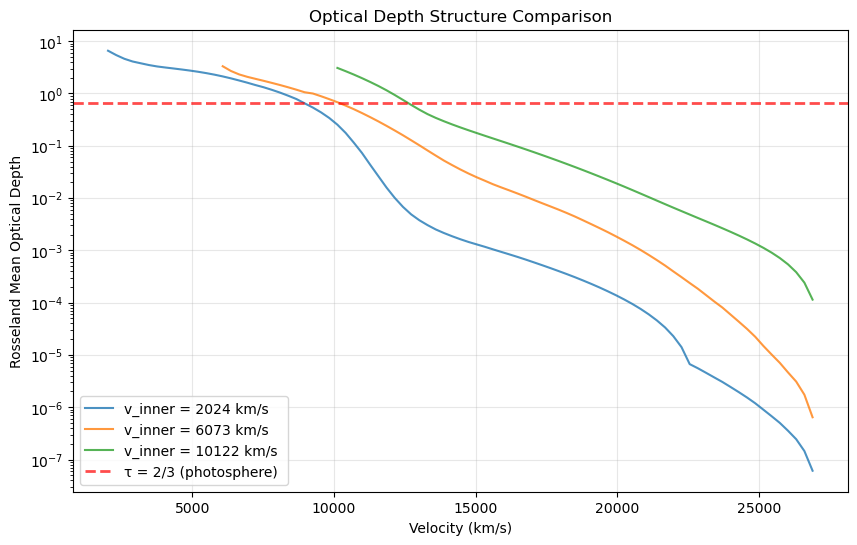

In [ ]:
sim_iter3 = run_tardis(
    config,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
)
sim_s = [sim_iter1, sim_iter2, sim_iter3]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for sim in sim_s:
    velocity = sim.simulation_state.v_inner.to(u.km / u.s)
    tau = get_tau_integ(
        sim.plasma,
        sim.opacity_state,
        sim.simulation_state,
    )["rosseland"].to(1)
    v_inner = sim.simulation_state.geometry.v_inner[0].to(u.km / u.s).value
    ax.plot(
        velocity,
        tau,
        alpha=0.8,
        label=f"v_inner = {v_inner:.0f} km/s ",
    )
ax.axhline(
    y=2 / 3,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="W = 0.5",
)
ax.set_xlabel("Velocity (km/s)")
ax.set_ylabel("Rosseland Mean Optical Depth")
ax.set_title("Optical Depth Structure Comparison")
ax.legend()
ax.set_yscale("log")
ax.grid(alpha=0.3)


BokehModel(combine_events=True, render_bundle={'docs_json': {'2ad627dc-0540-4e77-97e2-34cfd5dc1b5c': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': '99b1e4b3-472b-464d-aaaa-25eb1420d274', …

    'data': [{'type': 'scatter', 'uid': '99b1e4b3-472b-464d-aaaa-25eb1420d274', …

[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/workflows/util.py:73: RuntimeWarning:

overflow encountered in exp

 (warnings.py:110)
[py.warnings         ][WARNING]  /Users/jing/Software/tardis/tardis/wo

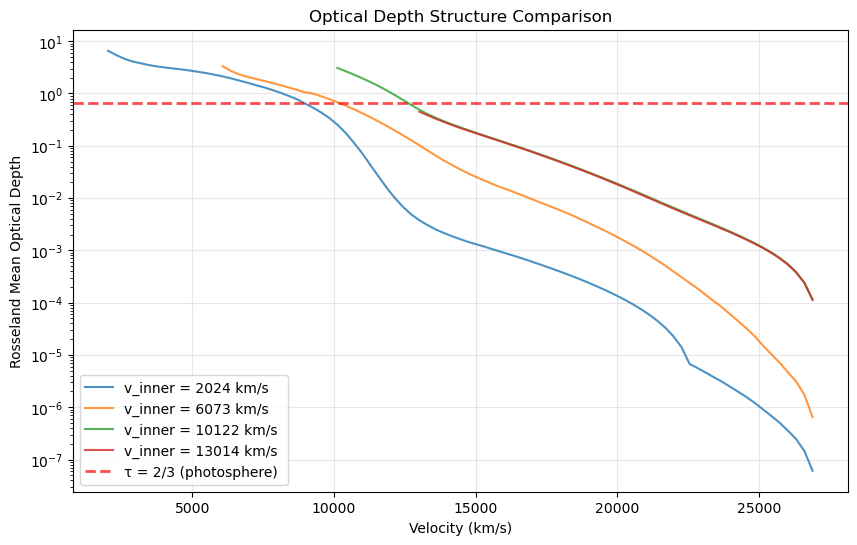

In [ ]:
sim_iter4 = run_tardis(
    config,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
)
sim_s = [sim_iter1, sim_iter2, sim_iter3, sim_iter4]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for sim in sim_s:
    velocity = sim.simulation_state.v_inner.to(u.km / u.s)
    tau = get_tau_integ(
        sim.plasma,
        sim.opacity_state,
        sim.simulation_state,
    )["rosseland"].to(1)
    v_inner = sim.simulation_state.geometry.v_inner[0].to(u.km / u.s).value
    ax.plot(
        velocity,
        tau,
        alpha=0.8,
        label=f"v_inner = {v_inner:.0f} km/s ",
    )
ax.axhline(
    y=2 / 3,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="W = 0.5",
)
ax.set_xlabel("Velocity (km/s)")
ax.set_ylabel("Rosseland Mean Optical Depth")
ax.set_title("Optical Depth Structure Comparison")
ax.legend()
ax.set_yscale("log")
ax.grid(alpha=0.3)


# Analyze the spectrum

Hopefully you have found a optimal v_inner_bounday when you reach here! Don't worry if you have not, you can still use the simulations you performed above to understand how does the change in v_inner_boundary change the simulation. 


**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

Use SDEC plot to visualize the ion contribution of the a simulation that has a v_inner_boundary too far in, and another one with v_inner boundary too far out. 

(in the extreme case, no packets will come out, code either enver end or crush ?????)

Think about ???? 

In [62]:
# your code here

(-2e+39, 3e+39)

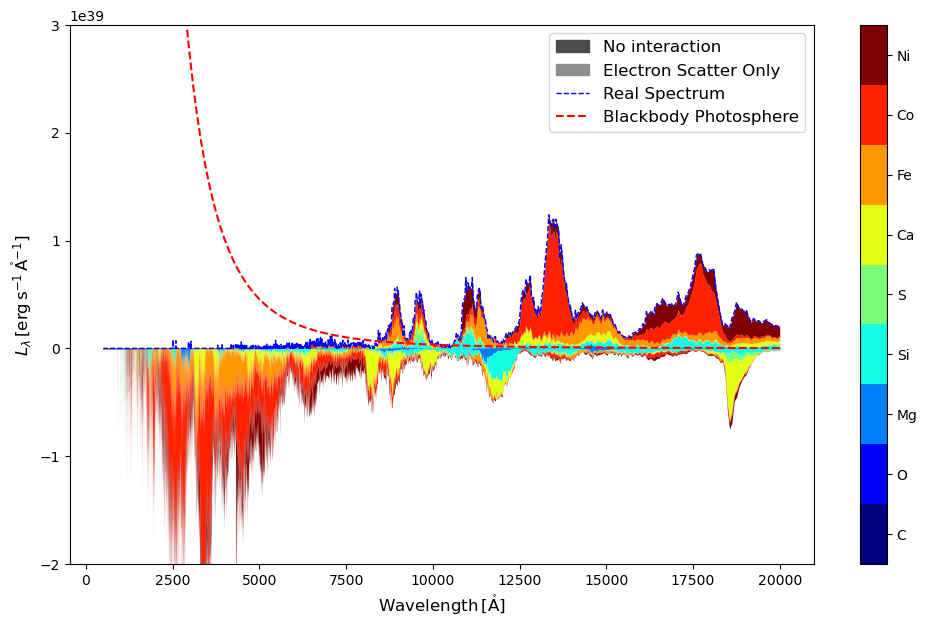

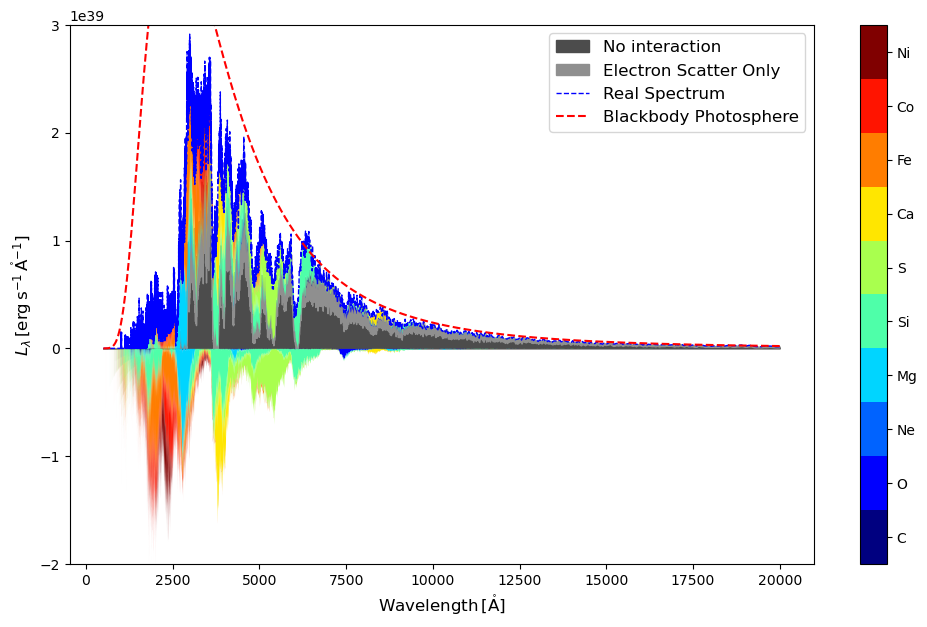

In [70]:
# plot the SDEC
sim = sim_iter1
sdec_plotter = SDECPlotter.from_simulation(sim)
sdec_plotter.generate_plot_mpl(
    packets_mode="real",
    # species_list=["C II", "Si II", "S II", "Ca I-II", "Fe II-III"],
)
plt.ylim(-2e39, 3e39)

sim = sim_iter4
sdec_plotter = SDECPlotter.from_simulation(sim)
sdec_plotter.generate_plot_mpl(
    packets_mode="real",
    # species_list=["C II", "Si II", "S II", "Ca I-II", "Fe II-III"],
)
plt.ylim(-2e39, 3e39)


**<span style="background-color: rgba(255, 255, 0, 0.3); padding: 4px;">📝Task</span>**

Use SDEC plot to visualize the ion contribution of the a simulation that has a v_inner_boundary too far in, and another one with v_inner boundary too far out. 


In [71]:
# your code here

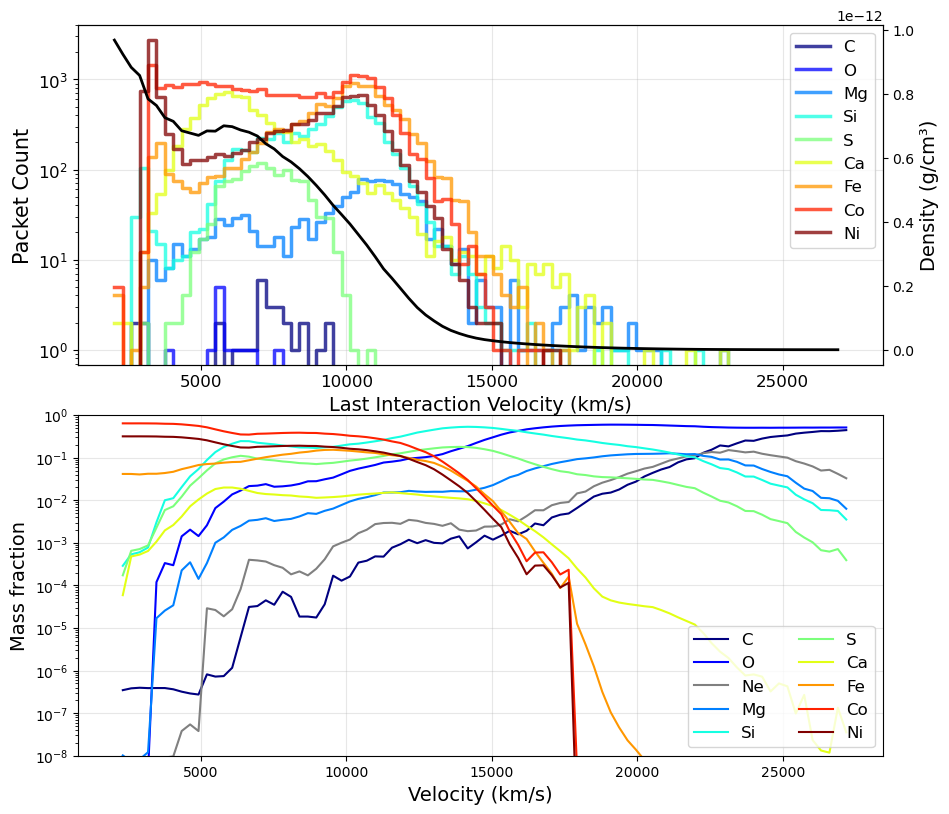

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
## LIV Plot - Line formation velocities
liv_plotter = LIVPlotter.from_simulation(sim)
liv_plotter.generate_plot_mpl(
    packets_mode="real",
    ylog_scale=True,
    # species_list=["C II", "Si II", "S II", "Ca I-II", "Fe II-III"],
    ax=axes[0],
)
axes[0].tick_params(labelsize=12, labelbottom=True)
axes[0].grid(alpha=0.3)
axes[0].legend(loc="upper right", fontsize=12, ncol=1)

## overlay the density on the same plot but using the y axis on the right
ax_twin = axes[0].twinx()
time_explosion = sim.simulation_state.time_explosion.to(u.day)
velocity = sim.simulation_state.v_inner.to(u.km / u.s).value
density = sim.simulation_state.density.to(u.g / u.cm**3).value
ax_twin.plot(
    velocity,
    density,
    "k-",
    lw=2,
    label=f"Density (g/cm³) at t={time_explosion:.1f} day",
)
ax_twin.set_ylabel("Density (g/cm³)", fontsize=14)


## plot the abundance in the other subplots\
velocity = simulation_state.v_outer.to(u.km / u.s).value
element_names = [
    atomic_number2element_symbol(Z)
    for Z in sim.simulation_state.composition.elemental_mass_fraction.index
]

# plot the abundance profiles first
# Extract legend handles color to match the elemental color
handles, labels = axes[0].get_legend_handles_labels()
colors = [h.get_color() for h in handles]
ax = axes[1]
for i, element_name in enumerate(element_names):
    if element_name in labels:
        element_index = labels.index(element_name)
        color = colors[element_index]
    else:
        color = "grey"  # default color if not found
    ax.plot(
        velocity,
        sim.simulation_state.composition.elemental_mass_fraction.iloc[i].values,
        label=element_name,
        color=color,
    )
ax.set_xlabel("Velocity (km/s)", fontsize=14)
ax.set_ylabel("Mass fraction", fontsize=14)
ax.legend(loc="lower right", fontsize=12, ncol=2)
ax.set_ylim(1e-8, 1e0)
ax.grid(alpha=0.3)
ax.set_yscale("log")


---

# **Summary and Takeaways**

Congratulations! You've now tasted how to work with hydrodynamic simulation data in TARDIS:

- **Model Visualization** - Examined density and abundance evolution from hydro simulations
- **Photospheric Velocity Optimization** - Used $\tau=2/3$ criterion to find optimal inner boundary velocity
- **Spectral Analysis** - Identified key features and their formation regions in synthetic spectra

---